# Rock Facies Classification: A Machine Learning Approach with Physics-Motivated Feature Augmentation

Author: Yu (Jason) Zeng  &nbsp; &nbsp;| &nbsp; &nbsp; Email: yu.zeng.duke@gmail.com &nbsp; &nbsp; | &nbsp; &nbsp; Date: Feb. 8, 2019

This notebook contains sample codes to build and train a gradient boosted tree-based model for rock facies classification using geophysical well log data. Our work shows that the inclusion of physics-motivated feature augmentation can further improve the capability of machine learning in rock facies classification. We demonstrate this approach with the SEG 2016 machine learning contest dataset and the top winner's solution. The improvement is roboust and is ~5% better than current existing best F-1 score.

This work is summarized in a paper entitled **Application of Machine Learning in Rock Facies Classification with Physics-Motivated Feature Augmentation** ([arxiv:1808.09856](https://arxiv.org/abs/1808.09856)) (co-author Jie Chen), and was presented in *2018 SEG Maximizing Asset Value through Artificial Intelligence and Machine Learning Workshop* ([2018 SEG Beijing Workshop](https://seg.org/Portals/0/SEG/Events/AIML_2018/Official_Program_AI_ML.pdf)). 

## Data Loading

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
data = pd.read_csv('training_data.csv')  
data.head(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915
5,3,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894
6,3,A1 SH,SHRIMPLIN,2796.0,73.72,0.630,15.6,13.930,3.7,1,0.872
7,3,A1 SH,SHRIMPLIN,2796.5,75.65,0.625,16.5,13.920,3.5,1,0.830
8,3,A1 SH,SHRIMPLIN,2797.0,73.79,0.624,16.2,13.980,3.4,1,0.809
9,3,A1 SH,SHRIMPLIN,2797.5,76.89,0.615,16.9,14.220,3.5,1,0.787


## Data QC: Number of measurements at each well

First, let's explore the dataset by checking the numebr of measurements for each well.

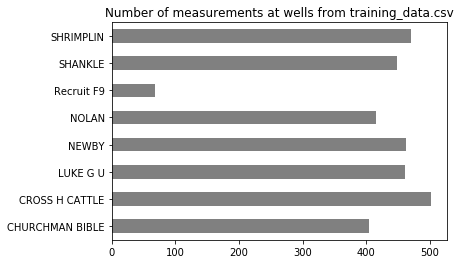

In [6]:
well_labels = ['CHURCHMAN BIBLE', 'CROSS H CATTLE', 'LUKE G U', 'NEWBY', 'NOLAN',
                 'Recruit F9', 'SHANKLE','SHRIMPLIN']

measure_count = data['Well Name'].value_counts().sort_index()
measure_count.index = well_labels

fig=plt.figure()
measure_count.plot(kind='barh',color='gray', 
                   title='Number of measurements at wells from training_data.csv')

It looks like except for well 'Recruit F9', the other wells have roughly the same numebr of measurements.

## Data QC: Check distribution of facies across each well

Next, let's check the distribution of rock facies within the whole dataset

['SHRIMPLIN' 'SHRIMPLIN' 'SHRIMPLIN' ... 'CHURCHMAN BIBLE'
 'CHURCHMAN BIBLE' 'CHURCHMAN BIBLE']


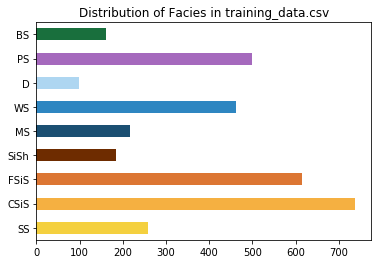

In [11]:
# 1=sandstone  2=c_siltstone   3=f_siltstone ​from confusion_matrix_utilities import plot_confusion_matrix
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

fig=plt.figure()

print(data['Well Name'].values)

facies_count = data['Facies'].value_counts().sort_index()
facies_count.index = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

facies_count.plot(kind='barh',color=facies_colors, 
                   title='Distribution of Facies in training_data.csv')

This QC suggests rock facies type CSiS is the most dominant type while "D" is the type with the least occurrence.

## Data QC: log10(ILD) distribution

Two attributes in the well log measurements caught our attention: Resistivity (R) and Neutron Density Porosity (P). Resistivity measures the ability of subsurface materials to resist or inhibit electrical conduction, while Neutron Density Porosity (P) measures subsurface materials’ porosity.

In [18]:
# define dictionary
dict={1: 'SS', 2: 'CSiS', 3: 'FSiS', 
      4: 'SiSh', 5: 'MS', 6: 'WS', 
      7: 'D', 8: 'PS', 9: 'BS'}

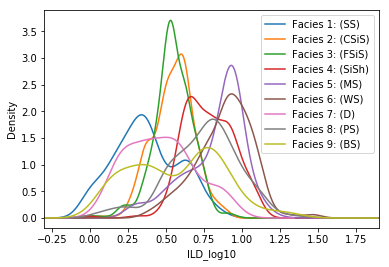

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('ILD_log10')
ax.set_xlim([-0.30, 1.9])
for i in range(1,10):
    x = data[data['Facies'] == i]['ILD_log10']
    label = "Facies " + str(i) + ": ("+ dict[i] + ")"
    x.plot(kind='density', label=label )
ax.legend(loc='best')

## Data QC: log10(PHIND) distribution

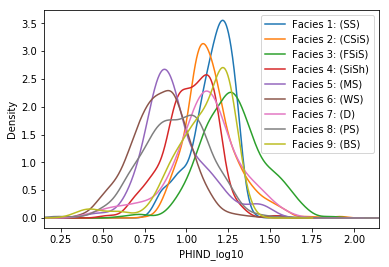

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PHIND_log10')
ax.set_xlim([0.15, 2.15])
for i in range(1,10):
    x = pd.np.log10(data[data['Facies'] == i]['PHIND'])
    label = "Facies " + str(i) + ": ("+ dict[i] + ")"
    x.plot(kind='density', label=label )
ax.legend(loc='best')

Intuitively, higher porosity means more pore space, indicating less resistivity in general. So to first order, those two quantities (R and P) should be negatively correlated. Is there any literature which has already studied the relationship between R and P in detail? Maybe we can gain some insight starting from there?

## Data QC: Investigate relationship between log10(ILD) vs. log10(PHIND)

We quickly found one empirical equation named after Gus Archie (1972). Archie summarized his observations and indicated the logarithmic forms log(R) and log(P) would be linearly anti-correlated under some assumptions. 

$log_{10} R = log_{10} C - m\cdot log_{10} P$

where $R$ is formation resistivity, $P$ is neutron density porosity, $C$ is tortuousity constant, and $m$ is cementation factor, which depends on rock formation.

To verify if Archie’s equation is applicable in this well log problem, we randomly picked 3 facies (1,3,7 in this case) and plotted the log(R) vs. log(P), overlaying with linear fitting curve. It turns out, at least for some classes (i.e. Facies 1 & 3 in this plot), the separation power is quite strong.

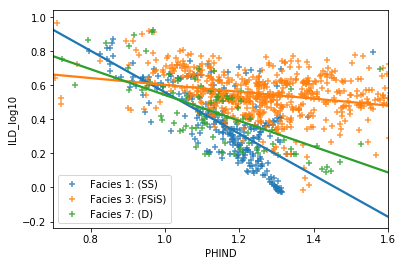

In [17]:
import seaborn as sns

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim([0.7, 1.6])
ax.set_xlabel('PHIND_log10')

for i in (1, 3, 7):
    x = pd.np.log10(data[data['Facies'] == i]['PHIND'])
    y = data[data['Facies'] == i]['ILD_log10']
    label = "Facies " + str(i) + ": ("+ dict[i] + ")"
    sns.regplot(x, y, marker='+', label=label, ci=1)
ax.legend(loc='best')

##  Construct new feature based on Archie's equation

Based on the observation, we construct a new feature based on Archie's equation by taking the logrithmic ratio of Porosity and Density.

In [20]:
#data['ILDoLogPhi'] = data['ILD_log10'] / pd.np.log10(data['PHIND'])
data['ILDoLogPhi'] = data['ILD_log10'] / data['PHIND']
data.head(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,ILDoLogPhi
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,0.055728
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,0.052606
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,0.050421
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,0.049943
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,0.048647
5,3,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894,0.047516
6,3,A1 SH,SHRIMPLIN,2796.0,73.72,0.630,15.6,13.930,3.7,1,0.872,0.045226
7,3,A1 SH,SHRIMPLIN,2796.5,75.65,0.625,16.5,13.920,3.5,1,0.830,0.044899
8,3,A1 SH,SHRIMPLIN,2797.0,73.79,0.624,16.2,13.980,3.4,1,0.809,0.044635
9,3,A1 SH,SHRIMPLIN,2797.5,76.89,0.615,16.9,14.220,3.5,1,0.787,0.043249


Same as TLE tutorial, we will save well "SHANKLE" as test well

In [21]:
data_test = data[data['Well Name'] == 'SHANKLE']   # test data
data = data[data['Well Name'] != 'SHANKLE']        # training data

Check dimension of test and train 

In [22]:
print(data_test.shape, data.shape)

(449, 12) (2783, 12)


Lets' do some data preprocessing and handle possible missing / NaN values.

In [23]:
features1 = ['GR', 'ILD_log10', 'DeltaPHI','PHIND','PE','NM_M', 'RELPOS']                 # features used in benchmark approach
features2 = ['GR', 'ILD_log10', 'DeltaPHI','PHIND','PE','NM_M', 'RELPOS','ILDoLogPhi']    # features used in our approach

# benchmark
feature_vectors1 = data[features1]
facies_labels1 = data['Facies']
feature_vectors1_test = data_test[features1]
facies_labels1_test = data_test['Facies']

# our approach
feature_vectors2 = data[features2]
facies_labels2 = data['Facies']
feature_vectors2_test = data_test[features2]
facies_labels2_test = data_test['Facies']

# Store well labels and depths
well = data['Well Name'].values
depth = data['Depth'].values
well_test = data_test['Well Name'].values
depth_test = data_test['Depth'].values

# Fill 'PE' missing values with mean
from sklearn import preprocessing
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(feature_vectors1)
print("Before transform: feature_vectors1.shape = ", feature_vectors1.shape)
feature_vectors1 = imp.transform(feature_vectors1)
print("After transform: feature_vectors.shape = ", feature_vectors1.shape)
imp.fit(feature_vectors1_test)
feature_vectors1_test = imp.transform(feature_vectors1_test)

imp.fit(feature_vectors2)
print("Before transform: feature_vectors1.shape = ", feature_vectors2.shape)
feature_vectors2 = imp.transform(feature_vectors2)
print("After transform: feature_vectors.shape = ", feature_vectors2.shape)
imp.fit(feature_vectors2_test)
feature_vectors2_test = imp.transform(feature_vectors2_test)

Before transform: feature_vectors1.shape =  (2783, 7)
After transform: feature_vectors.shape =  (2783, 7)
Before transform: feature_vectors1.shape =  (2783, 8)
After transform: feature_vectors.shape =  (2783, 8)


C:\Users\idrun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Feature augmentations

General feature augmentation used in top winner's approach. This will be used as benchmark to justify the uplift from our physics-motivated feature augmentation.

In [24]:
# Code borrowed from Top winner LA Team https://github.com/seg/2016-ml-contest/blob/master/LA_Team/
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
#def augment_features(X, well, depth, N_neig=0):   

    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

# Feature 2nd derivative computation function
def augment_features_2nd_derivative(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    # Compute feature gradient on X_grad
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X_grad, axis=0)
    X_grad2 = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad2 = np.concatenate((X_grad2, np.zeros((1, X_grad2.shape[1]))))
    
    return X_grad2

# Feature augmentation function 2
def augment_features2(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+3)))  # N_neig*2 +2 --> N_neig*2 + 3
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug_2nd_derivative = augment_features_2nd_derivative(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad, X_aug_2nd_derivative), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

## Apply general feature augmentation

We apply the same general feature augmentation as Top winner's approach. The difference between benchmark approach and our approach is only the new feature $log_{10} R /log_{10}P $ we have created.

In [28]:
# ---- for benchmark approach ----------------
X_aug1, padded_rows1 = augment_features(feature_vectors1, well, depth)
X_aug1_test, padded_rows1_test = augment_features(feature_vectors1_test, well_test, depth_test)

# ---- for our approach ----------------------
X_aug2, padded_rows2 = augment_features(feature_vectors2, well, depth)
X_aug2_test, padded_rows2_test = augment_features(feature_vectors2_test, well_test, depth_test)

print('Benchmark   :  X_aug1.shape = ', X_aug1.shape, '\t X_aug1_test.shape = ', X_aug1_test.shape)
print('Our approach:  X_aug2.shape = ', X_aug2.shape, '\t X_aug2_test.shape = ', X_aug2_test.shape)

Benchmark   :  X_aug1.shape =  (2783, 28) 	 X_aug1_test.shape =  (449, 28)
Our approach:  X_aug2.shape =  (2783, 32) 	 X_aug2_test.shape =  (449, 32)


## Normalize both train and test consistently

Normalize both train and test in the same way

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_aug1)
scaled_features1 = scaler.transform(X_aug1) #ndarray now. 
scaled_features1_test = scaler.transform(X_aug1_test) #ndarray now. 
print('scaled_features1.shape', scaled_features1.shape)

scaler = StandardScaler().fit(X_aug2)
scaled_features2 = scaler.transform(X_aug2) #ndarray now. 
scaled_features2_test = scaler.transform(X_aug2_test) #ndarray now. 
print('scaled_features2.shape', scaled_features2.shape)

scaled_features1.shape (2783, 28)
scaled_features2.shape (2783, 32)


Let's split train and CV datasets.

In [30]:
from sklearn.model_selection import train_test_split
X_train1, X_cv1, y_train1, y_cv1 = train_test_split(scaled_features1, facies_labels1,test_size=0.05, random_state=42,stratify=facies_labels1)
print('Benchmark   :  X_train1.shape', X_train1.shape)

X_train2, X_cv2, y_train2, y_cv2 = train_test_split(scaled_features2, facies_labels2,test_size=0.05, random_state=42,stratify=facies_labels2)
print('Our approach:  X_train2.shape', X_train2.shape)

Benchmark   :  X_train1.shape (2643, 28)
Our approach:  X_train2.shape (2643, 32)


In [31]:
# // XGboost + same parameters as Top Winner LA Team
from xgboost.sklearn import  XGBClassifier
# benchmark
clf1 = XGBClassifier(learning_rate=0.12,max_depth=3,min_child_weight=10,n_estimators=150,seed=100,colsample_bytree=0.9)
clf1.fit(X_train1, y_train1)
# our approach
clf2 = XGBClassifier(learning_rate=0.12,max_depth=3,min_child_weight=10,n_estimators=150,seed=100,colsample_bytree=0.9)
from sklearn.metrics import classification_report

In [32]:
target_names = ['SS', 'CSiS', 'FSiS', 'SiSh','MS', 'WS', 'D','PS', 'BS']
clf2.fit(X_train2, y_train2)

y_cv1_pred = clf1.predict(X_cv1) 
print('Benchmark:')
print(classification_report(y_cv1, y_cv1_pred,target_names=target_names, digits=3))

y_cv2_pred = clf2.predict(X_cv2) 
print('Our approach:')
print(classification_report(y_cv2, y_cv2_pred,target_names=target_names, digits=3))

Benchmark:
              precision    recall  f1-score   support

          SS      0.875     0.875     0.875         8
        CSiS      0.737     0.848     0.789        33
        FSiS      0.810     0.680     0.739        25
        SiSh      0.455     0.556     0.500         9
          MS      0.625     0.500     0.556        10
          WS      0.765     0.650     0.703        20
           D      0.750     0.750     0.750         4
          PS      0.615     0.696     0.653        23
          BS      0.857     0.750     0.800         8

   micro avg      0.714     0.714     0.714       140
   macro avg      0.721     0.701     0.707       140
weighted avg      0.723     0.714     0.715       140

Our approach:
              precision    recall  f1-score   support

          SS      0.875     0.875     0.875         8
        CSiS      0.757     0.848     0.800        33
        FSiS      0.818     0.720     0.766        25
        SiSh      0.500     0.556     0.526         9

In [33]:
y_pred1 = clf1.predict(scaled_features1_test)
y_pred2 = clf2.predict(scaled_features2_test)

print('Benchmark:')
print(classification_report(facies_labels1_test, y_pred1,target_names=target_names[0:8], digits=3))
print('Our approach:')
print(classification_report(facies_labels2_test, y_pred2,target_names=target_names[0:8], digits=3))

Benchmark:
              precision    recall  f1-score   support

          SS      0.778     0.393     0.522        89
        CSiS      0.422     0.820     0.557        89
        FSiS      0.833     0.556     0.667       117
        SiSh      0.150     0.429     0.222         7
          MS      0.000     0.000     0.000        19
          WS      0.716     0.746     0.731        71
           D      0.900     0.529     0.667        17
          PS      0.667     0.700     0.683        40

   micro avg      0.592     0.592     0.592       449
   macro avg      0.558     0.522     0.506       449
weighted avg      0.664     0.592     0.593       449

Our approach:
              precision    recall  f1-score   support

          SS      0.822     0.416     0.552        89
        CSiS      0.423     0.831     0.561        89
        FSiS      0.867     0.556     0.677       117
        SiSh      0.158     0.429     0.231         7
          MS      0.000     0.000     0.000        19

Benchmark:

Normalized confusion matrix
[[0.39325843 0.58426966 0.02247191 0.         0.         0.
  0.         0.        ]
 [0.06741573 0.82022472 0.11235955 0.         0.         0.
  0.         0.        ]
 [0.03418803 0.41025641 0.55555556 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.42857143 0.         0.28571429
  0.         0.28571429]
 [0.         0.         0.         0.73684211 0.         0.26315789
  0.         0.        ]
 [0.         0.         0.01408451 0.04225352 0.07042254 0.74647887
  0.         0.12676056]
 [0.         0.         0.         0.         0.11764706 0.17647059
  0.52941176 0.17647059]
 [0.         0.         0.         0.         0.         0.275
  0.025      0.7       ]]
 
Our approach:

Normalized confusion matrix
[[0.41573034 0.57303371 0.01123596 0.         0.         0.
  0.         0.        ]
 [0.06741573 0.83146067 0.08988764 0.         0.01123596 0.
  0.         0.        ]
 [0.01709402 0.42735043 0.555

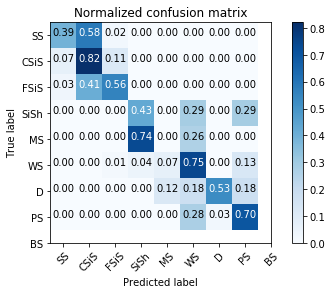

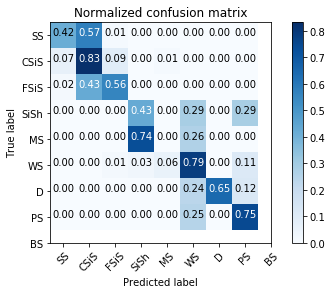

In [34]:
# Use confusion matrix to evaluate, by providing actual and predicted facies labels
from sklearn.metrics import confusion_matrix
from confusion_matrix_utilities import plot_confusion_matrix #,  plot_confusion_matrix2
import matplotlib.pyplot as plt

# confusion matrix for XGBoost with feature augmentation
conf1 = confusion_matrix(facies_labels1_test, y_pred1)  # confusion matrix 'conf' is 9x9 ndarray (conf.shape)
print('Benchmark:\n')
fig = plt.figure()
plot_confusion_matrix(conf1, classes=facies_labels, normalize=True,
                      title='Normalized confusion matrix')

print(' ')
conf2 = confusion_matrix(facies_labels2_test, y_pred2)
print('Our approach:\n')
fig=plt.figure()
plot_confusion_matrix(conf2, classes=facies_labels, normalize=True,
                      title='Normalized confusion matrix')

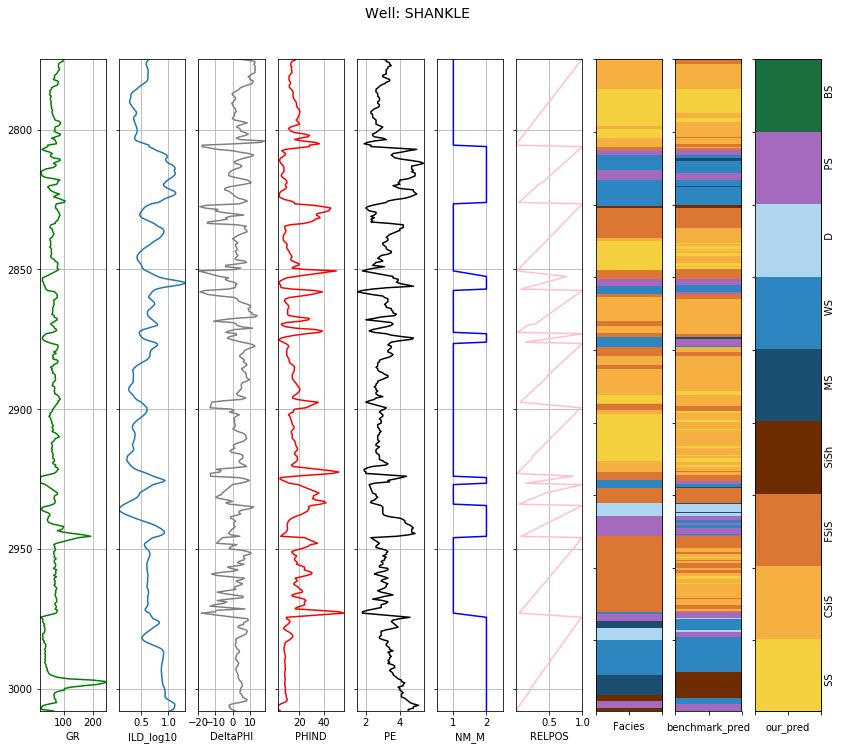

In [35]:
from well_log_plot_utilities import compare_facies_plot3

data_test['benchmark_pred'] = y_pred1
data_test['our_pred'] = y_pred2

fig=compare_facies_plot3(data_test.sort_values(by='Depth'), 'benchmark_pred', 'our_pred', facies_colors)
